In [18]:
!pip install torch torchvision matplotlib scikit-learn --quiet




In [19]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q PennFudanPed.zip


--2025-05-20 06:17:12--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  8.81MB/s    in 7.3s    

2025-05-20 06:17:20 (6.98 MB/s) - ‘PennFudanPed.zip.1’ saved [53723336/53723336]

replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PennFudanPed/Annotation/FudanPed00001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PennFudanPed/Annotation/FudanPed00002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PennFudanPed/Annotation/FudanPed00003.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PennFudanPed/Annotation/FudanPed00004.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [20]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import random


In [21]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)[1:]  # 0 arka plan
        masks = mask == obj_ids[:, None, None]

        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # sadece kişi sınıfı
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [22]:
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as T

transform = T.Compose([T.ToTensor()])
dataset = PennFudanDataset("PennFudanPed", transforms=transform)

# %60 train, %20 val, %20 test
total = len(dataset)
train_size = int(0.6 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [23]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)  # 1: person + 1: background
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [24]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0
    for imgs, targets in loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    return total_loss / len(loader)


In [25]:
num_epochs = 10  # Test için az tut, sonra 100 yaparsın
train_losses = []

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device)
    train_losses.append(loss)
    lr_scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.4f}")


Epoch [1/10] Loss: 0.2580
Epoch [2/10] Loss: 0.1151
Epoch [3/10] Loss: 0.0864
Epoch [4/10] Loss: 0.0761
Epoch [5/10] Loss: 0.0670
Epoch [6/10] Loss: 0.0501
Epoch [7/10] Loss: 0.0442
Epoch [8/10] Loss: 0.0420
Epoch [9/10] Loss: 0.0403
Epoch [10/10] Loss: 0.0395


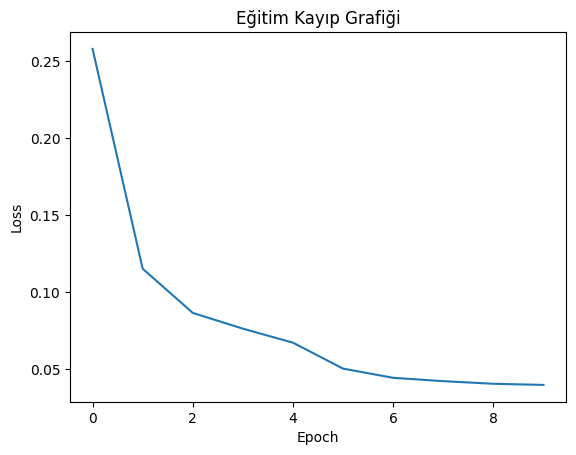

In [26]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim Kayıp Grafiği")
plt.show()


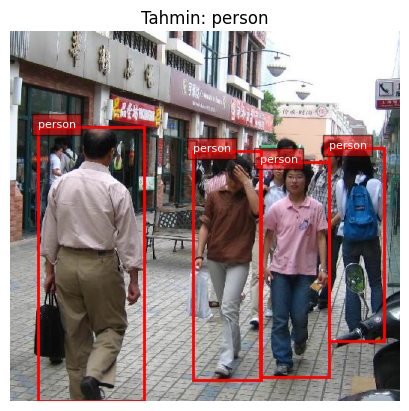

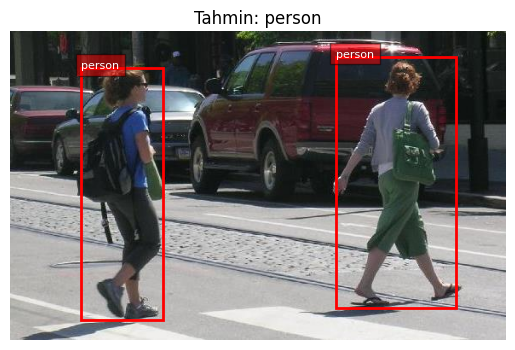

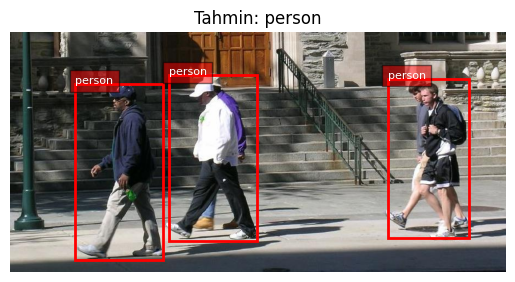

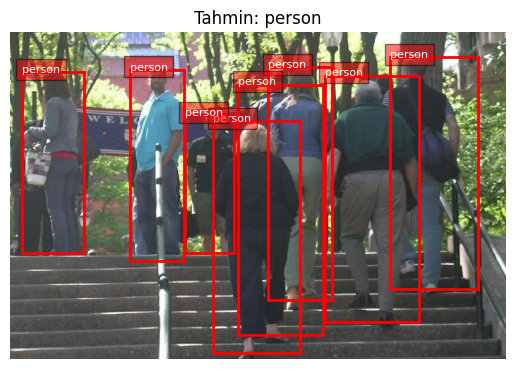

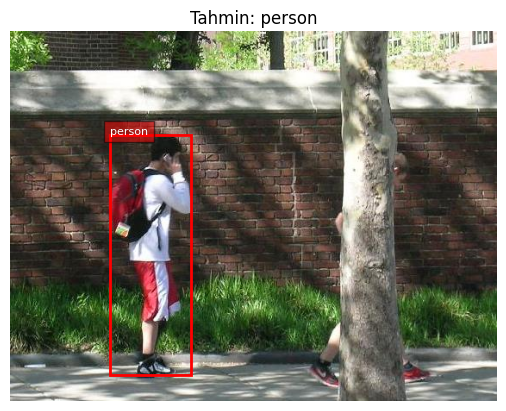

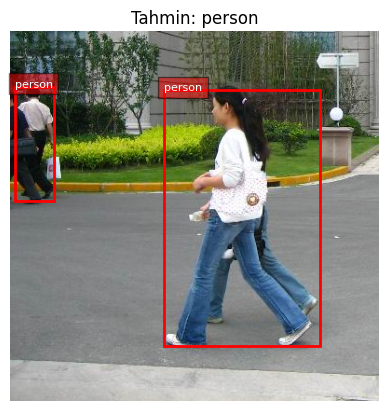

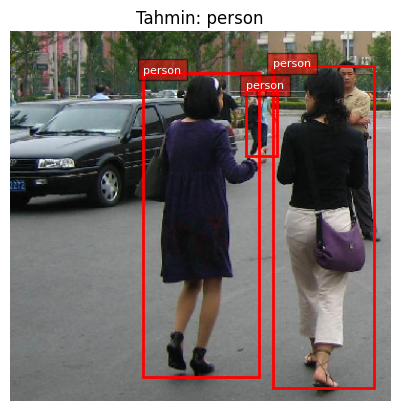

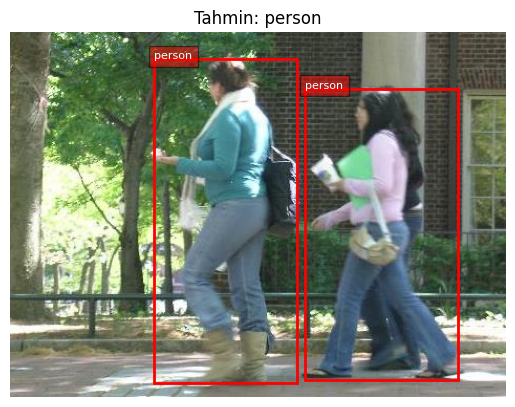

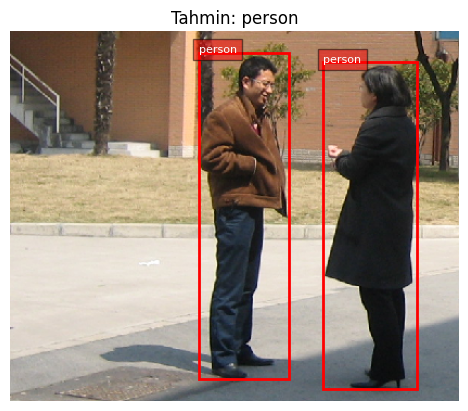

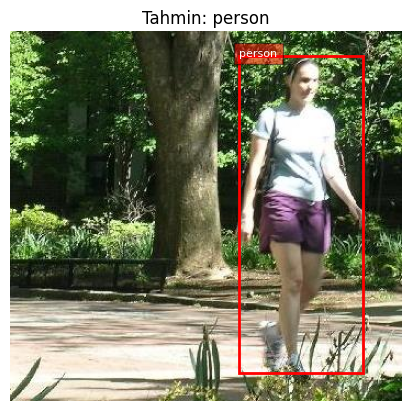

In [27]:
import random

model.eval()
with torch.no_grad():
    test_samples = random.sample(list(test_loader), 10)  # rastgele 10 örnek

    for imgs, targets in test_samples:
        img = imgs[0].to(device)
        output = model([img])[0]

        img = img.permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)

        for i, box in enumerate(output['boxes']):
            box = box.cpu().numpy()
            xmin, ymin, xmax, ymax = box
            label = output['labels'][i].item()
            # Sadece kişi sınıfını ve belirli bir güven skorunun üzerindekileri gösterelim
            score = output['scores'][i].item() # Güven skorunu al
            if label == 1 and score > 0.5: # Güven skoru 0.5'ten büyükse göster
                label_name = "person"

                plt.gca().add_patch(
                    plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                  edgecolor='red', facecolor='none', linewidth=2))
                plt.text(xmin, ymin, label_name, color='white',
                         fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        plt.axis("off")
        plt.title("Tahmin: person")
        plt.show()